In [0]:
!python mlip_setup_env.py

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


# Notebook from Kaggle
But with WandB integration and tensorflow 2.0. Adapted from https://www.kaggle.com/kaushal2896/bengali-graphemes-starter-eda-multi-output-cnn.


In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm.auto import tqdm
from glob import glob
import time, gc
import cv2

%tensorflow_version 2.x
# from tensorflow import keras
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import clone_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import PIL.Image as Image, PIL.ImageDraw as ImageDraw, PIL.ImageFont as ImageFont
from matplotlib import pyplot as plt
import seaborn as sns

# Weights and Biases integration
import wandb
from wandb.keras import WandbCallback

# import helper functions
from starter_eda_model_funcs import resize, get_dummies, get_model

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
print("Data files:")
for dirname, _, filenames in os.walk('Data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

TensorFlow 2.x selected.
Data files:
Data/train_image_data_3.parquet
Data/test_image_data_2.parquet
Data/test_image_data_3.parquet
Data/test.csv
Data/train_image_data_0.parquet
Data/sample_submission.csv
Data/data
Data/train_image_data_1.parquet
Data/train_image_data_2.parquet
Data/test_image_data_0.parquet
Data/train.csv
Data/test_image_data_1.parquet
Data/class_map.csv


In [0]:
from helper import GlobalAccuracyCallback, train

In [0]:
# Any results you write to the current directory are saved as output.

train_df_ = pd.read_csv('Data/train.csv')
test_df_ = pd.read_csv('Data/test.csv')
class_map_df = pd.read_csv('Data/class_map.csv')
sample_sub_df = pd.read_csv('Data/sample_submission.csv')
train_df_ = train_df_.drop(['grapheme'], axis=1, inplace=False)

print(f'Size of training data: {train_df_.shape}')
print(f'Size of test data: {test_df_.shape}')
print(f'Size of class map: {class_map_df.shape}')

print(f'Number of unique grapheme roots: {train_df_["grapheme_root"].nunique()}')
print(f'Number of unique vowel diacritic: {train_df_["vowel_diacritic"].nunique()}')
print(f'Number of unique consonant diacritic: {train_df_["consonant_diacritic"].nunique()}')

# define original image size
HEIGHT = 137
WIDTH = 236
# define target image size
IMG_SIZE = 64
N_CHANNELS = 1
# define training parameters
batch_size = 256
epochs = 30

Size of training data: (200840, 4)
Size of test data: (36, 3)
Size of class map: (186, 3)
Number of unique grapheme roots: 168
Number of unique vowel diacritic: 11
Number of unique consonant diacritic: 7


# Baseline

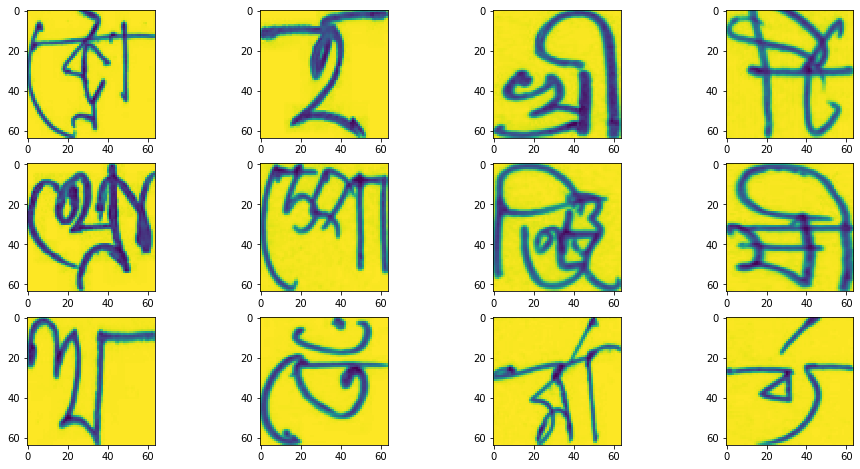


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
  {'out_root': '...', 'out_vowel': '...', 'out_consonant': '...'}
    to  
  ['...', '...', '...']
Train for 180 steps, validate on 4017 samples
Epoch 1/30
180/180 [==============================] - 32s 175ms/step - loss: 7.6171 - out_root_loss: 4.7207 - out_vowel_loss: 1.7218 - out_consonant_loss: 1.1746 - out_root_acc: 0.0326 - out_vowel_acc: 0.3834 - out_consonant_acc: 0.6228 - val_loss: 6.8391 - val_out_root_loss: 4.5430 - val_out_vowel_loss: 1.2813 - val_out_consonant_loss: 1.0165 - val_out_root_acc: 0.0376 - val_out_vowel_acc: 0.5554 - val_out_consonant_acc: 0.6395
Epoch 2/30
180/180 [==============================] - 27s 150ms/step - loss: 6.5157 - out_root_loss: 4.4254 - out_vowel_loss: 1.1156 - out_consonant_loss: 0.9747 - out_root_acc: 0.0448 - out_vowel_acc: 0.6135 - out_consonant_acc: 0.6562 - val_loss: 5.6267 - val_out_root_loss:

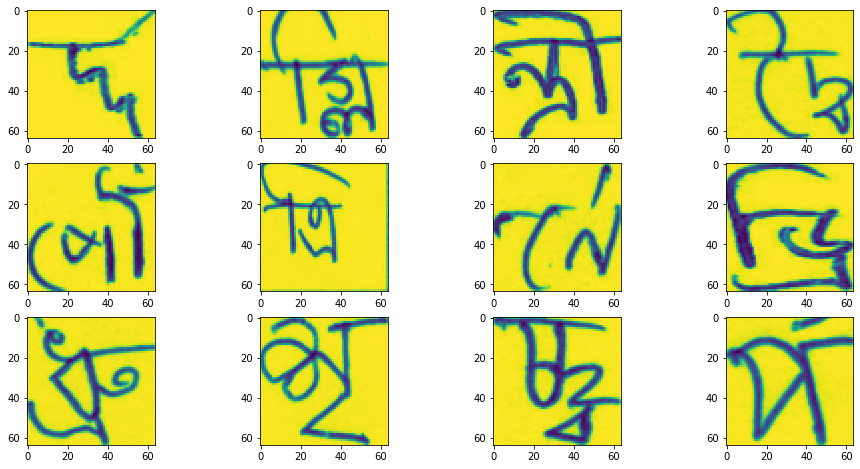


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
  {'out_root': '...', 'out_vowel': '...', 'out_consonant': '...'}
    to  
  ['...', '...', '...']
Train for 180 steps, validate on 4017 samples
Epoch 1/30
180/180 [==============================] - 27s 148ms/step - loss: 0.9758 - out_root_loss: 0.5714 - out_vowel_loss: 0.2350 - out_consonant_loss: 0.1695 - out_root_acc: 0.8452 - out_vowel_acc: 0.9319 - out_consonant_acc: 0.9489 - val_loss: 0.5227 - val_out_root_loss: 0.3360 - val_out_vowel_loss: 0.0988 - val_out_consonant_loss: 0.0884 - val_out_root_acc: 0.9099 - val_out_vowel_acc: 0.9729 - val_out_consonant_acc: 0.9761
Epoch 2/30
180/180 [==============================] - 27s 147ms/step - loss: 0.8876 - out_root_loss: 0.5088 - out_vowel_loss: 0.2219 - out_consonant_loss: 0.1569 - out_root_acc: 0.8584 - out_vowel_acc: 0.9368 - out_consonant_acc: 0.9523 - val_loss: 0.4986 - val_out_root_loss:

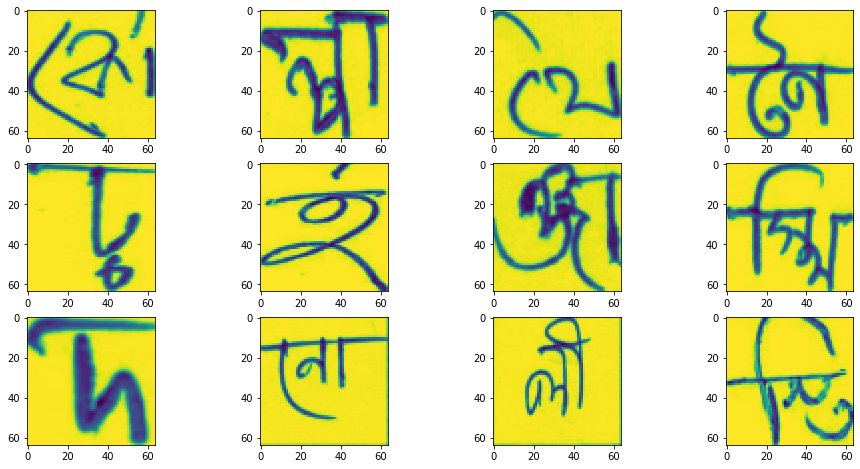


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
  {'out_root': '...', 'out_vowel': '...', 'out_consonant': '...'}
    to  
  ['...', '...', '...']
Train for 180 steps, validate on 4017 samples
Epoch 1/30
180/180 [==============================] - 27s 148ms/step - loss: 0.6362 - out_root_loss: 0.3653 - out_vowel_loss: 0.1562 - out_consonant_loss: 0.1147 - out_root_acc: 0.9030 - out_vowel_acc: 0.9555 - out_consonant_acc: 0.9668 - val_loss: 0.3492 - val_out_root_loss: 0.2106 - val_out_vowel_loss: 0.0751 - val_out_consonant_loss: 0.0662 - val_out_root_acc: 0.9460 - val_out_vowel_acc: 0.9826 - val_out_consonant_acc: 0.9806
Epoch 2/30
180/180 [==============================] - 27s 148ms/step - loss: 0.5523 - out_root_loss: 0.3148 - out_vowel_loss: 0.1377 - out_consonant_loss: 0.0998 - out_root_acc: 0.9129 - out_vowel_acc: 0.9610 - out_consonant_acc: 0.9698 - val_loss: 0.3399 - val_out_root_loss:

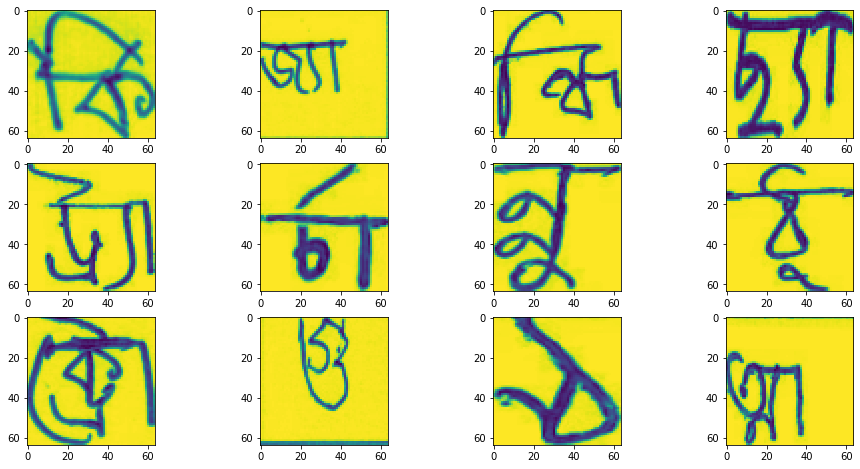


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
  {'out_root': '...', 'out_vowel': '...', 'out_consonant': '...'}
    to  
  ['...', '...', '...']
Train for 180 steps, validate on 4017 samples
Epoch 1/30
180/180 [==============================] - 27s 148ms/step - loss: 0.5407 - out_root_loss: 0.3118 - out_vowel_loss: 0.1331 - out_consonant_loss: 0.0958 - out_root_acc: 0.9199 - out_vowel_acc: 0.9626 - out_consonant_acc: 0.9727 - val_loss: 0.3129 - val_out_root_loss: 0.1863 - val_out_vowel_loss: 0.0778 - val_out_consonant_loss: 0.0474 - val_out_root_acc: 0.9500 - val_out_vowel_acc: 0.9836 - val_out_consonant_acc: 0.9863
Epoch 2/30
180/180 [==============================] - 27s 148ms/step - loss: 0.5070 - out_root_loss: 0.2907 - out_vowel_loss: 0.1261 - out_consonant_loss: 0.0901 - out_root_acc: 0.9219 - out_vowel_acc: 0.9642 - out_consonant_acc: 0.9726 - val_loss: 0.3101 - val_out_root_loss:

In [0]:
datagen_args = dict(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=8,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.15, # Randomly zoom image 
    width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False
)

model = get_model(loss_weights={'out_root': 1., 'out_vowel': 1., 'out_consonant': 1.})
train(train_df_, datagen_args, name='Loss plain', model=model)

# Weighted loss
The root accuracy counts for 50%, while vowel and consonant count for 25%. To reflect this in the loss, apply a weight of 2, 1, 1 to the individual losses. 

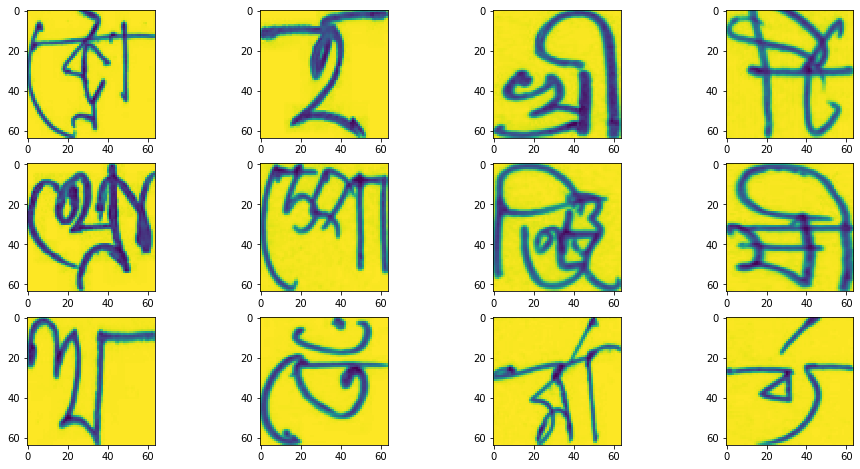


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
  {'out_root': '...', 'out_vowel': '...', 'out_consonant': '...'}
    to  
  ['...', '...', '...']
Train for 180 steps, validate on 4017 samples
Epoch 1/30
179/180 [============================>.] - ETA: 0s - loss: 12.4407 - out_root_loss: 4.6890 - out_vowel_loss: 1.8661 - out_consonant_loss: 1.1966 - out_root_acc: 0.0305 - out_vowel_acc: 0.3280 - out_consonant_acc: 0.6235Global accuracy for epoch 0 is 0.306510
1
180/180 [==============================] - 32s 179ms/step - loss: 12.4365 - out_root_loss: 4.6883 - out_vowel_loss: 1.8642 - out_consonant_loss: 1.1958 - out_root_acc: 0.0305 - out_vowel_acc: 0.3288 - out_consonant_acc: 0.6235 - val_loss: 11.0950 - val_out_root_loss: 4.3911 - val_out_vowel_loss: 1.3439 - val_out_consonant_loss: 0.9698 - val_out_root_acc: 0.0413 - val_out_vowel_acc: 0.4864 - val_out_consonant_acc: 0.6570
Epoch 2/30
17

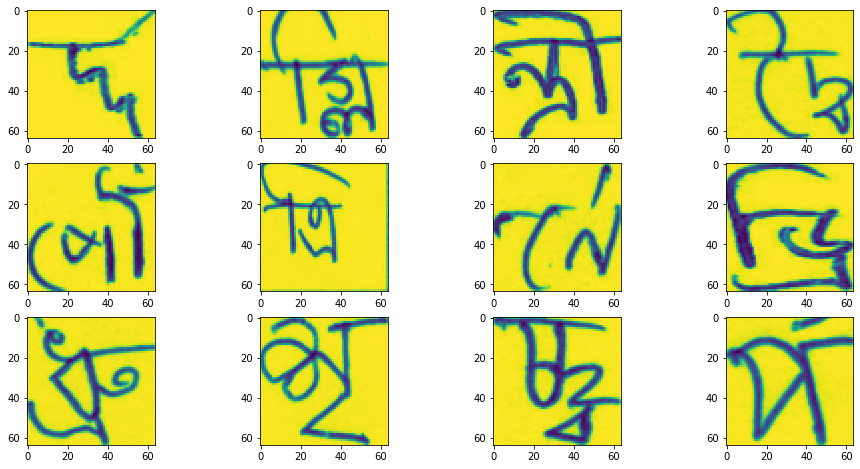


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
  {'out_root': '...', 'out_vowel': '...', 'out_consonant': '...'}
    to  
  ['...', '...', '...']
Train for 180 steps, validate on 4017 samples
Epoch 1/30
179/180 [============================>.] - ETA: 0s - loss: 1.5615 - out_root_loss: 0.5558 - out_vowel_loss: 0.2651 - out_consonant_loss: 0.1848 - out_root_acc: 0.8510 - out_vowel_acc: 0.9238 - out_consonant_acc: 0.9442Global accuracy for epoch 0 is 0.944984
31
180/180 [==============================] - 28s 155ms/step - loss: 1.5605 - out_root_loss: 0.5551 - out_vowel_loss: 0.2653 - out_consonant_loss: 0.1849 - out_root_acc: 0.8512 - out_vowel_acc: 0.9236 - out_consonant_acc: 0.9441 - val_loss: 0.8192 - val_out_root_loss: 0.3000 - val_out_vowel_loss: 0.1286 - val_out_consonant_loss: 0.0903 - val_out_root_acc: 0.9201 - val_out_vowel_acc: 0.9651 - val_out_consonant_acc: 0.9746
Epoch 2/30
179/

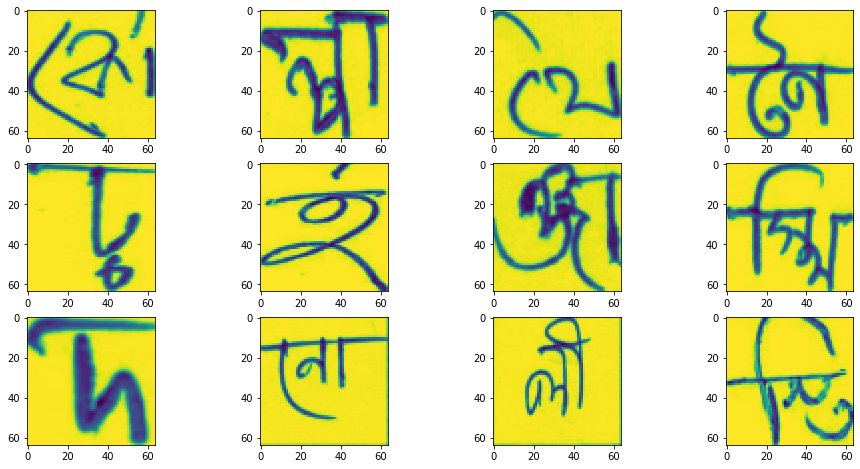


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
  {'out_root': '...', 'out_vowel': '...', 'out_consonant': '...'}
    to  
  ['...', '...', '...']
Train for 180 steps, validate on 4017 samples
Epoch 1/30
179/180 [============================>.] - ETA: 0s - loss: 1.0867 - out_root_loss: 0.3886 - out_vowel_loss: 0.1791 - out_consonant_loss: 0.1304 - out_root_acc: 0.8972 - out_vowel_acc: 0.9501 - out_consonant_acc: 0.9618Global accuracy for epoch 0 is 0.960480
61
180/180 [==============================] - 28s 155ms/step - loss: 1.0867 - out_root_loss: 0.3883 - out_vowel_loss: 0.1793 - out_consonant_loss: 0.1308 - out_root_acc: 0.8972 - out_vowel_acc: 0.9500 - out_consonant_acc: 0.9617 - val_loss: 0.6121 - val_out_root_loss: 0.2263 - val_out_vowel_loss: 0.0882 - val_out_consonant_loss: 0.0730 - val_out_root_acc: 0.9422 - val_out_vowel_acc: 0.9768 - val_out_consonant_acc: 0.9806
Epoch 2/30
179/

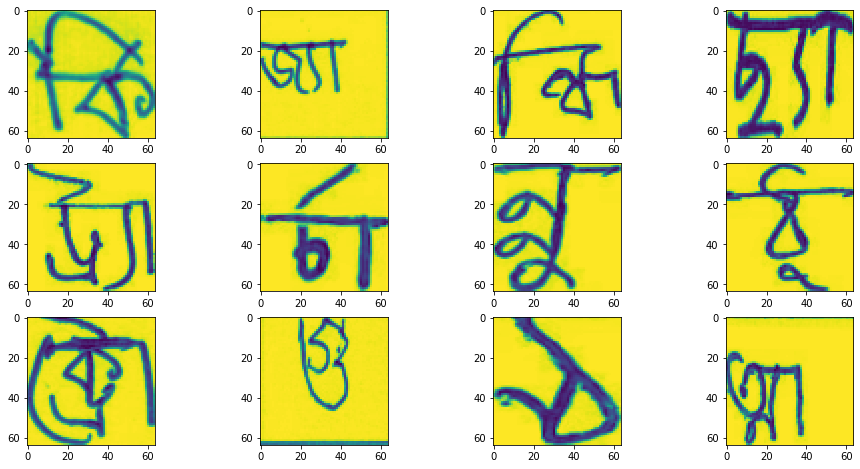


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
  {'out_root': '...', 'out_vowel': '...', 'out_consonant': '...'}
    to  
  ['...', '...', '...']
Train for 180 steps, validate on 4017 samples
Epoch 1/30
179/180 [============================>.] - ETA: 0s - loss: 0.8863 - out_root_loss: 0.3210 - out_vowel_loss: 0.1427 - out_consonant_loss: 0.1017 - out_root_acc: 0.9201 - out_vowel_acc: 0.9609 - out_consonant_acc: 0.9710Global accuracy for epoch 0 is 0.965335
91
180/180 [==============================] - 28s 155ms/step - loss: 0.8862 - out_root_loss: 0.3209 - out_vowel_loss: 0.1428 - out_consonant_loss: 0.1016 - out_root_acc: 0.9201 - out_vowel_acc: 0.9609 - out_consonant_acc: 0.9710 - val_loss: 0.5271 - val_out_root_loss: 0.1982 - val_out_vowel_loss: 0.0774 - val_out_consonant_loss: 0.0499 - val_out_root_acc: 0.9462 - val_out_vowel_acc: 0.9818 - val_out_consonant_acc: 0.9871
Epoch 2/30
179/

In [0]:
datagen_args = dict(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=8,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.15, # Randomly zoom image 
    width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False
)

model = get_model(loss_weights={'out_root': 2., 'out_vowel': 1., 'out_consonant': 1.})
train(train_df_, datagen_args, name='Loss weight', model=model)

# Data augmentation

### Featurewise zscore normalization
Setting `featurewise_center` and `samplewise_center` to true along with `featurewise_std_normalization` and `samplewise_std_normalization` resulted in deteriorating performance. Strangly, the images when plotted looked very similar. This run will revert to the first run, and only set featurewise's to true, which is the actually intended zscore normalization. 

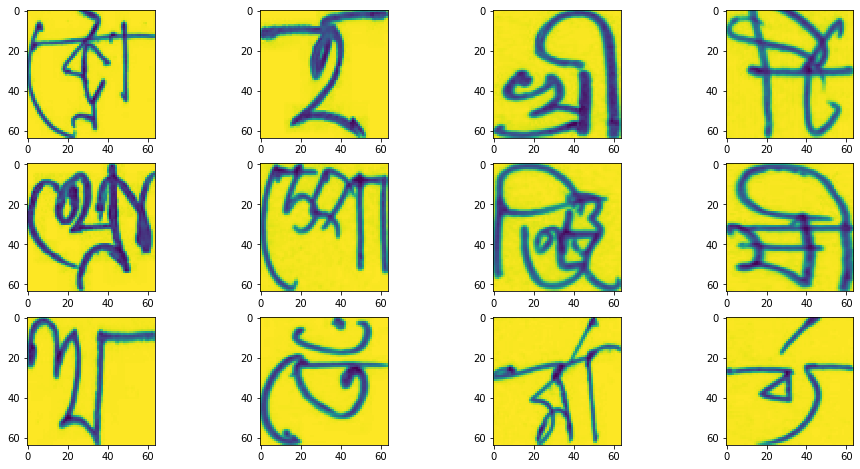


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
  {'out_root': '...', 'out_vowel': '...', 'out_consonant': '...'}
    to  
  ['...', '...', '...']
Train for 180 steps, validate on 4017 samples
Epoch 1/30
180/180 [==============================] - 41s 228ms/step - loss: 12.2100 - out_root_loss: 4.6696 - out_vowel_loss: 1.6883 - out_consonant_loss: 1.1826 - out_root_acc: 0.0351 - out_vowel_acc: 0.4063 - out_consonant_acc: 0.6203 - val_loss: 19.0878 - val_out_root_loss: 6.0852 - val_out_vowel_loss: 5.3610 - val_out_consonant_loss: 1.5554 - val_out_root_acc: 0.0164 - val_out_vowel_acc: 0.0899 - val_out_consonant_acc: 0.6107
Epoch 2/30
180/180 [==============================] - 31s 169ms/step - loss: 10.8675 - out_root_loss: 4.2782 - out_vowel_loss: 1.3071 - out_consonant_loss: 1.0039 - out_root_acc: 0.0585 - out_vowel_acc: 0.5326 - out_consonant_acc: 0.6606 - val_loss: 18.3586 - val_out_root_l

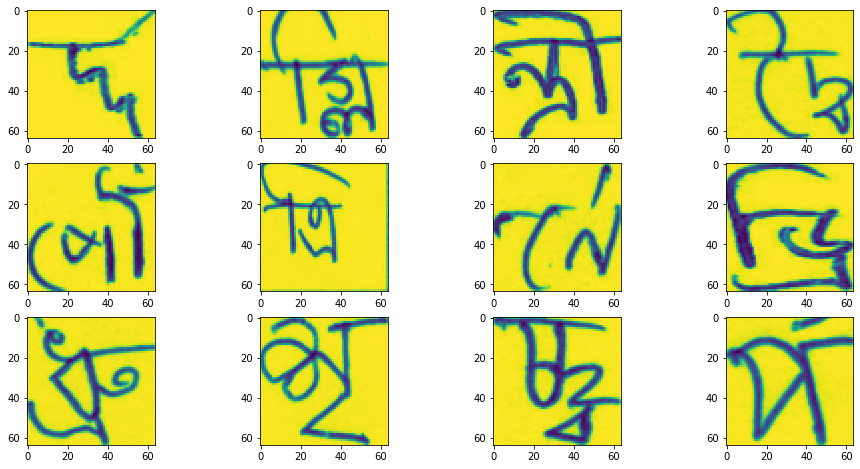


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
  {'out_root': '...', 'out_vowel': '...', 'out_consonant': '...'}
    to  
  ['...', '...', '...']
Train for 180 steps, validate on 4017 samples
Epoch 1/30
180/180 [==============================] - 31s 170ms/step - loss: 1.5595 - out_root_loss: 0.5553 - out_vowel_loss: 0.2611 - out_consonant_loss: 0.1879 - out_root_acc: 0.8502 - out_vowel_acc: 0.9253 - out_consonant_acc: 0.9427 - val_loss: 1.6042 - val_out_root_loss: 0.5573 - val_out_vowel_loss: 0.3324 - val_out_consonant_loss: 0.1514 - val_out_root_acc: 0.8571 - val_out_vowel_acc: 0.8994 - val_out_consonant_acc: 0.9510
Epoch 2/30
180/180 [==============================] - 29s 162ms/step - loss: 1.3592 - out_root_loss: 0.4763 - out_vowel_loss: 0.2359 - out_consonant_loss: 0.1706 - out_root_acc: 0.8683 - out_vowel_acc: 0.9317 - out_consonant_acc: 0.9485 - val_loss: 2.1023 - val_out_root_loss:

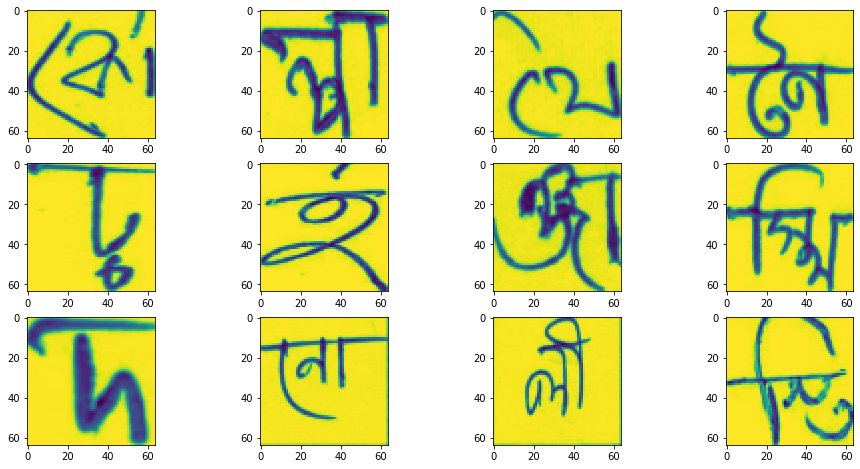


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
  {'out_root': '...', 'out_vowel': '...', 'out_consonant': '...'}
    to  
  ['...', '...', '...']
Train for 180 steps, validate on 4017 samples
Epoch 1/30
180/180 [==============================] - 30s 168ms/step - loss: 0.9703 - out_root_loss: 0.3461 - out_vowel_loss: 0.1570 - out_consonant_loss: 0.1212 - out_root_acc: 0.9093 - out_vowel_acc: 0.9558 - out_consonant_acc: 0.9639 - val_loss: 1.6636 - val_out_root_loss: 0.5639 - val_out_vowel_loss: 0.3862 - val_out_consonant_loss: 0.1516 - val_out_root_acc: 0.8509 - val_out_vowel_acc: 0.8875 - val_out_consonant_acc: 0.9517
Epoch 2/30
180/180 [==============================] - 30s 165ms/step - loss: 0.8702 - out_root_loss: 0.3028 - out_vowel_loss: 0.1522 - out_consonant_loss: 0.1124 - out_root_acc: 0.9160 - out_vowel_acc: 0.9570 - out_consonant_acc: 0.9663 - val_loss: 1.8871 - val_out_root_loss:

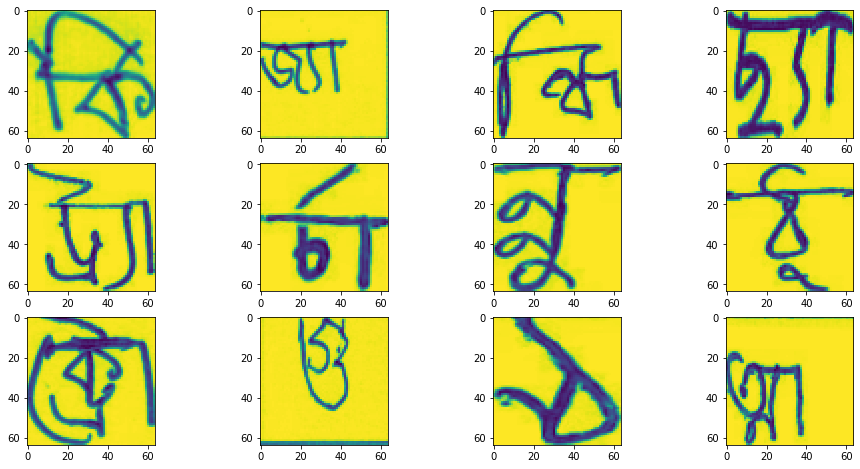


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
  {'out_root': '...', 'out_vowel': '...', 'out_consonant': '...'}
    to  
  ['...', '...', '...']
Train for 180 steps, validate on 4017 samples
Epoch 1/30
180/180 [==============================] - 30s 168ms/step - loss: 0.8519 - out_root_loss: 0.3042 - out_vowel_loss: 0.1391 - out_consonant_loss: 0.1043 - out_root_acc: 0.9213 - out_vowel_acc: 0.9605 - out_consonant_acc: 0.9699 - val_loss: 2.3793 - val_out_root_loss: 0.7764 - val_out_vowel_loss: 0.6058 - val_out_consonant_loss: 0.2186 - val_out_root_acc: 0.8178 - val_out_vowel_acc: 0.8305 - val_out_consonant_acc: 0.9368
Epoch 2/30
180/180 [==============================] - 30s 168ms/step - loss: 0.8366 - out_root_loss: 0.2985 - out_vowel_loss: 0.1396 - out_consonant_loss: 0.1001 - out_root_acc: 0.9222 - out_vowel_acc: 0.9593 - out_consonant_acc: 0.9700 - val_loss: 2.2867 - val_out_root_loss:

In [0]:
datagen_args = dict(
    featurewise_center=True,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=True,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=8,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.15, # Randomly zoom image 
    width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False
)

model = get_model()
train(train_df_, datagen_args, name='Featurewise zscore', model=model)

### Samplewise zscore
Now use the samplewise zscore normalization instead of the dataset level zscore normalization. 

wandb: Network error resolved after 0:00:27.911092, resuming normal operation.



Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)


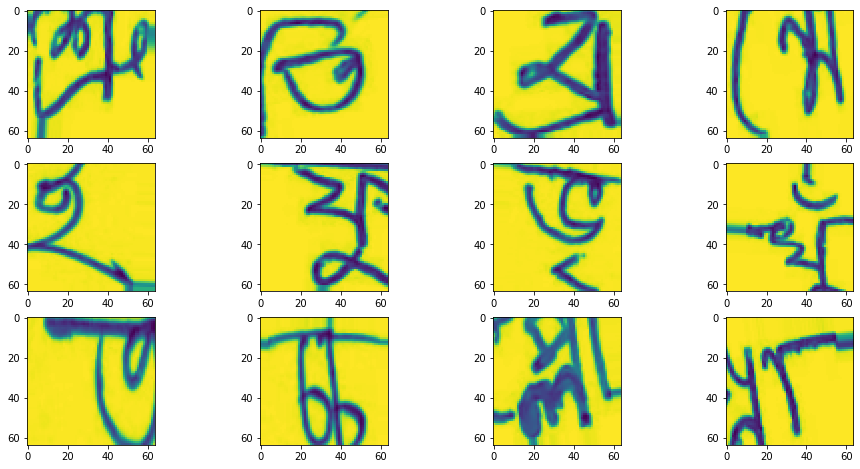

  {'out_root': '...', 'out_vowel': '...', 'out_consonant': '...'}
    to  
  ['...', '...', '...']
Train for 180 steps, validate on 4017 samples
Epoch 1/30
  7/180 [>.............................] - ETA: 10:30 - loss: 16.4422 - out_root_loss: 5.5202 - out_vowel_loss: 2.8316 - out_consonant_loss: 2.5702 - out_root_acc: 0.0156 - out_vowel_acc: 0.1530 - out_consonant_acc: 0.4609

KeyboardInterrupt: ignored

In [0]:
datagen_args = dict(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=True,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=True,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=8,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.15, # Randomly zoom image 
    width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False
)

model = get_model()
train(train_df_, datagen_args, name='Samplewise zscore', model=model)

### ZCA whitening
ZCA whitening on, zscores off. 


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)


/tensorflow-2.1.0/python3.6/keras_preprocessing/image/image_data_generator.py:336: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


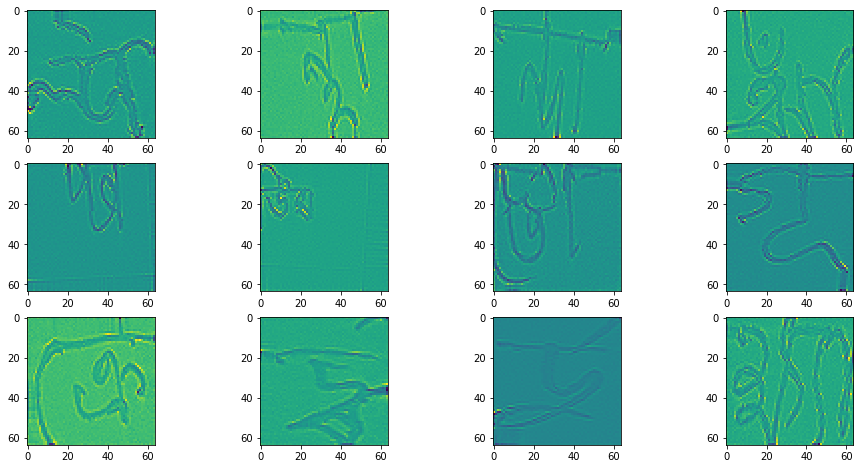

  {'out_root': '...', 'out_vowel': '...', 'out_consonant': '...'}
    to  
  ['...', '...', '...']
Train for 180 steps, validate on 4017 samples
Epoch 1/30
 15/180 [=>............................] - ETA: 15:51 - loss: 14.8318 - out_root_loss: 5.2362 - out_vowel_loss: 2.6014 - out_consonant_loss: 1.7581 - out_root_acc: 0.0128 - out_vowel_acc: 0.1869 - out_consonant_acc: 0.5474

KeyboardInterrupt: ignored

In [0]:
datagen_args = dict(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=True,  # apply ZCA whitening
    rotation_range=8,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.15, # Randomly zoom image 
    width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False
)

model = get_model()
train(train_df_, datagen_args, name='ZCA whitening', model=model)

### Shear

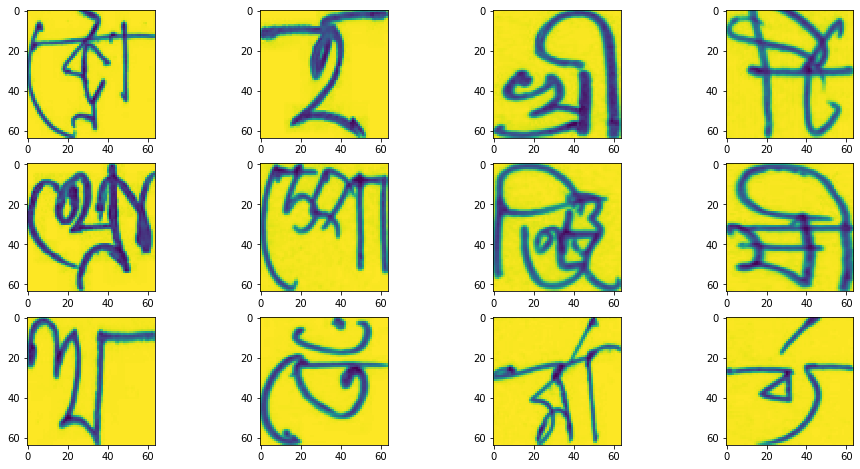


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
  {'out_root': '...', 'out_vowel': '...', 'out_consonant': '...'}
    to  
  ['...', '...', '...']
Train for 180 steps, validate on 4017 samples
Epoch 1/30
180/180 [==============================] - 29s 160ms/step - loss: 12.4485 - out_root_loss: 4.6883 - out_vowel_loss: 1.9163 - out_consonant_loss: 1.1556 - out_root_acc: 0.0326 - out_vowel_acc: 0.3057 - out_consonant_acc: 0.6300 - val_loss: 11.3525 - val_out_root_loss: 4.4489 - val_out_vowel_loss: 1.3927 - val_out_consonant_loss: 1.0591 - val_out_root_acc: 0.0480 - val_out_vowel_acc: 0.4797 - val_out_consonant_acc: 0.6226
Epoch 2/30
180/180 [==============================] - 27s 148ms/step - loss: 11.2201 - out_root_loss: 4.3799 - out_vowel_loss: 1.4446 - out_consonant_loss: 1.0158 - out_root_acc: 0.0511 - out_vowel_acc: 0.4763 - out_consonant_acc: 0.6605 - val_loss: 9.9439 - val_out_root_lo

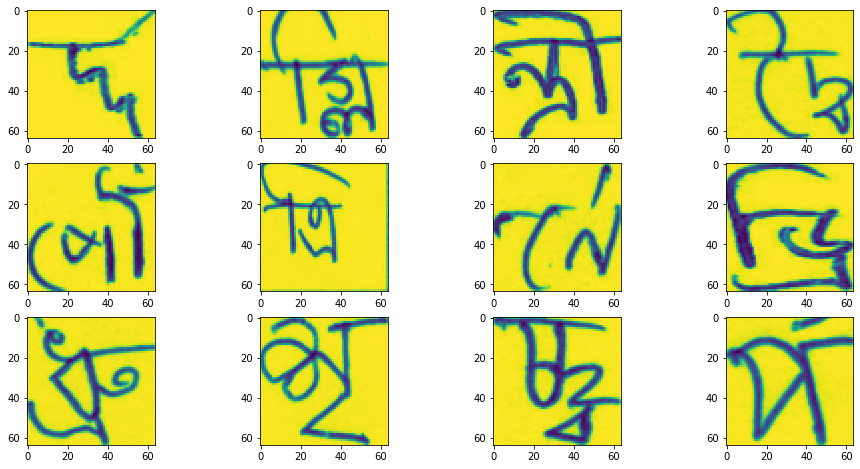


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
  {'out_root': '...', 'out_vowel': '...', 'out_consonant': '...'}
    to  
  ['...', '...', '...']
Train for 180 steps, validate on 4017 samples
Epoch 1/30
180/180 [==============================] - 27s 148ms/step - loss: 1.6120 - out_root_loss: 0.5734 - out_vowel_loss: 0.2740 - out_consonant_loss: 0.1911 - out_root_acc: 0.8468 - out_vowel_acc: 0.9198 - out_consonant_acc: 0.9410 - val_loss: 0.8436 - val_out_root_loss: 0.3036 - val_out_vowel_loss: 0.1355 - val_out_consonant_loss: 0.0974 - val_out_root_acc: 0.9198 - val_out_vowel_acc: 0.9651 - val_out_consonant_acc: 0.9721
Epoch 2/30
180/180 [==============================] - 27s 148ms/step - loss: 1.4236 - out_root_loss: 0.4979 - out_vowel_loss: 0.2516 - out_consonant_loss: 0.1762 - out_root_acc: 0.8627 - out_vowel_acc: 0.9264 - out_consonant_acc: 0.9445 - val_loss: 0.7769 - val_out_root_loss:

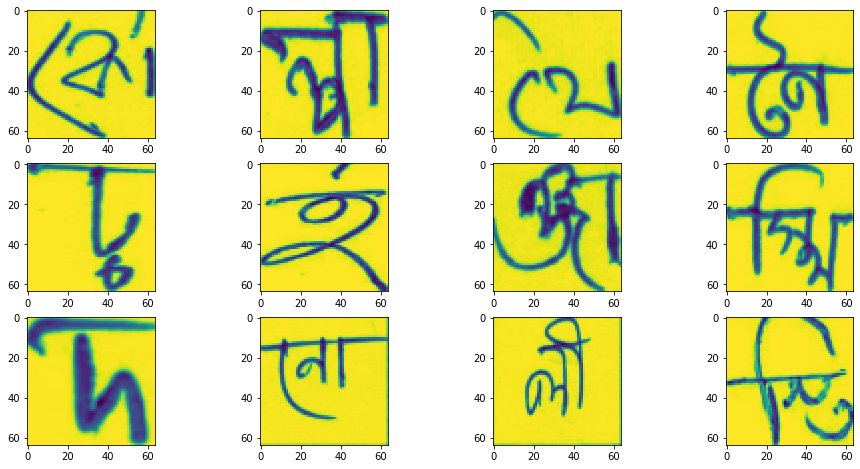


Training images: (50210, 64, 64, 1)
Training labels root: (50210, 168)
Training labels vowel: (50210, 11)
Training labels consonants: (50210, 7)
  {'out_root': '...', 'out_vowel': '...', 'out_consonant': '...'}
    to  
  ['...', '...', '...']
Train for 180 steps, validate on 4017 samples
Epoch 1/30
180/180 [==============================] - 27s 149ms/step - loss: 1.2264 - out_root_loss: 0.4345 - out_vowel_loss: 0.2065 - out_consonant_loss: 0.1508 - out_root_acc: 0.8849 - out_vowel_acc: 0.9408 - out_consonant_acc: 0.9545 - val_loss: 0.6461 - val_out_root_loss: 0.2375 - val_out_vowel_loss: 0.0839 - val_out_consonant_loss: 0.0902 - val_out_root_acc: 0.9368 - val_out_vowel_acc: 0.9776 - val_out_consonant_acc: 0.9719
Epoch 2/30
180/180 [==============================] - 27s 148ms/step - loss: 1.0642 - out_root_loss: 0.3646 - out_vowel_loss: 0.1966 - out_consonant_loss: 0.1384 - out_root_acc: 0.8984 - out_vowel_acc: 0.9444 - out_consonant_acc: 0.9580 - val_loss: 0.6137 - val_out_root_loss:

In [0]:
datagen_args = dict(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=8,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.15, # Randomly zoom image 
    width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False,
    shear_range=8, #Shear Intensity (Shear angle in counter-clockwise direction in degrees)
)

model = get_model()
train(train_df_, datagen_args, name='Shear 8 deg', model=model)

# Results
Results should be taken with a grain of salt, as each setting was done one run, no cross validation whatsoever.  

**Loss weighting**  
Not a significant difference. 

**Data augmentation**  
The data augmentation results in bits from the graphemes to fall off from the image. The augmentations are probably great, but would be even better if the order would be swapped with the cropping. Or perhaps allow some wiggle room.  

In the current tests, performance was as follows.  
Shear: worse, perhaps due to padding (clipping).   
Featurewise zscore: much worse.  
Samplewise zscore: too slow.   
ZCA whitening: too slow. 
